Загрузка библиотек

In [1]:
import os
import time
import glob
import cv2
import PIL
import albumentations as A
import skimage.io as io
from albumentations.pytorch.transforms import ToTensorV2

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import  f1_score, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
import torchvision.models as models
import gc
from IPython.display import clear_output
%matplotlib inline

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/PLANTS/plants_desease.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: plants_desease/e00c97b2de4749ce.jpg  
  inflating: plants_desease/e00df890cfe62736.jpg  
  inflating: plants_desease/e00ed0bf43a87f25.jpg  
  inflating: plants_desease/e00f759d65d52887.jpg  
  inflating: plants_desease/e00f934d9e50ad5b.jpg  
  inflating: plants_desease/e00fce341cb63da5.jpg  
  inflating: plants_desease/e010c7c35ecf3d1c.jpg  
  inflating: plants_desease/e01112939f783fec.jpg  
  inflating: plants_desease/e01592da4d71b8be.jpg  
  inflating: plants_desease/e0189acaf8cf80fd.jpg  
  inflating: plants_desease/e0189e4999bdd0fa.jpg  
  inflating: plants_desease/e01ae16d4a759cb5.jpg  
  inflating: plants_desease/e01dc39ccb2b4ccb.jpg  
  inflating: plants_desease/e01e42d90c66f3f3.jpg  
  inflating: plants_desease/e01e870bec65f40f.jpg  
  inflating: plants_desease/e01f17e0187fb80f.jpg  
  inflating: plants_desease/e01f503cb752e6c5.jpg  
  inflating: plants_desease/e024b69a784e9fc3.jpg  
  inflating: p

Загружаем данные

In [4]:
train_dir = '/content/plants_desease/'
df = pd.read_csv('/content/drive/MyDrive/PLANTS/train.csv')
df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [5]:
df.labels.value_counts()

labels
scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: count, dtype: int64

Визуализация классов

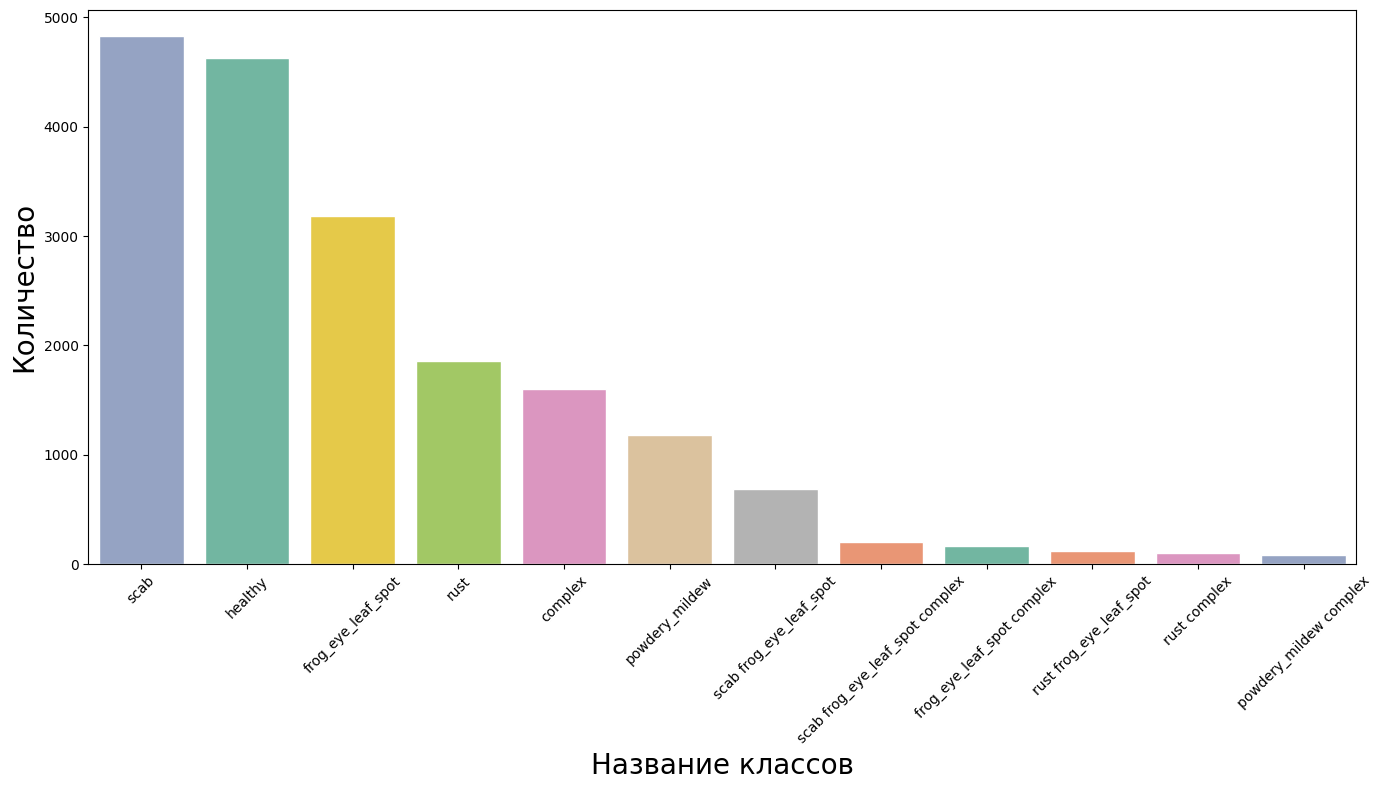

In [6]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.set_style("whitegrid")

sns.countplot(
    x='labels',
    palette="Set2",
    hue='labels',
    data=df,
    order=df['labels'].value_counts().index,
);

plt.ylabel("Количество", size=20);
plt.xlabel("Название классов", size=20)

plt.xticks(rotation=45)

fig.tight_layout()
plt.show()

При просмотре классов, получается в датасете имеется не 12 различных классов, а 6 классов:

1.   scab
2.   healthy
3.   frog_eye_leaf_spot
4.   rust
5.   complex                            
6.   powdery_mildew

Оставшие классы - это несколько болезней, которые могут присутствовать на листке одновременно.


One hot encoding классов

In [7]:
df['labels'] = df['labels'].apply(lambda string: string.split(' '))
s = list(df['labels'])
mlb = MultiLabelBinarizer()
img_labels = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=df.index)
img_labels.insert(0, "image", df['image'], True)
img_labels.head()

,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,1,1,0,0,0,1
2,80070f7fb5e2ccaa.jpg,0,0,0,0,0,1
3,80077517781fb94f.jpg,0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,1,0,0,0,0,0


In [8]:
CLASSES = [
        'complex',
        'frog_eye_leaf_spot',
        'healthy',
        'powdery_mildew',
        'rust',
        'scab'
    ]

Визуализирую 6 классов

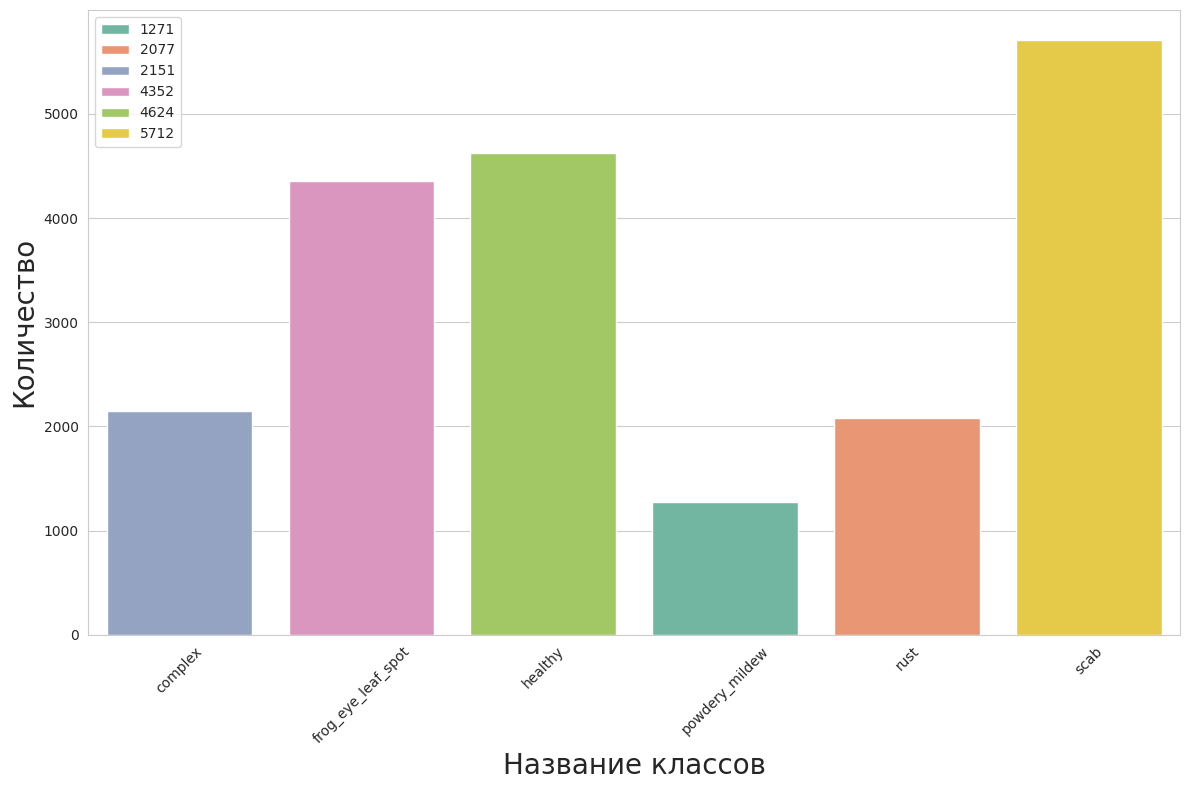

In [9]:
labels = img_labels[CLASSES].sum().keys()
label_counts = img_labels[CLASSES].sum().values.tolist()
fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.set_style("whitegrid")


sns.barplot(x= labels, y= label_counts, ax=ax, hue=label_counts, palette="Set2", order=labels)

plt.ylabel("Количество", size=20);
plt.xlabel("Название классов", size=20)

plt.xticks(rotation=45)

fig.tight_layout()
plt.show()

Визуализация изображений датасета

In [10]:
def visualize_images(image_ids, labels, directory, nrows=1, ncols=4, image_transform=None):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
    for image_id, label, ax in zip(image_ids, labels, axes.flatten()):

        fname = os.path.join(directory, image_id)
        image = np.array(PIL.Image.open(fname))

        if image_transform:
            image = transform = A.Compose(
                [t for t in image_transform.transforms if not isinstance(t, (
                    A.Normalize,
                    ToTensorV2
                ))])(image=image)['image']

        io.imshow(image, ax=ax)

        ax.set_title(f"Class: {label}", fontsize=12)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        del image

    plt.show()

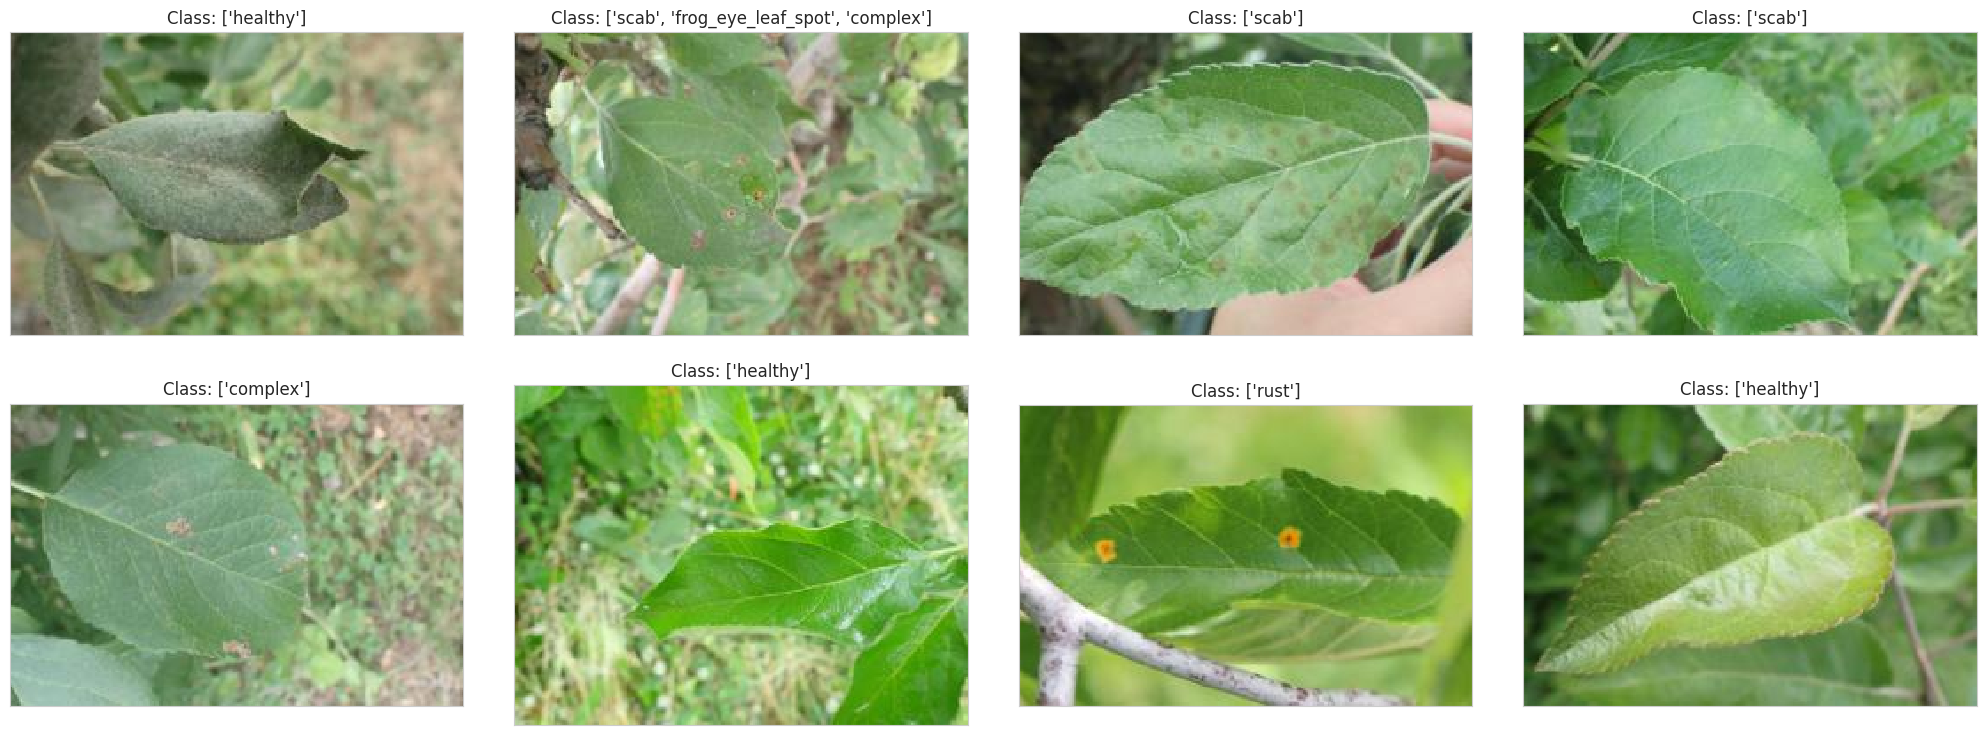

In [11]:
visualize_images(df.image, df.labels, train_dir, nrows=2, ncols=4)

In [12]:
input_size = (224, 224)

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.CoarseDropout(max_height=int(input_size[0] * 0.15), max_width=int(input_size[1] * 0.15), max_holes=1, p=0.5),
    A.MultiplicativeNoise(p=0.5, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [13]:
images = df.sample(n=5)

Пример аугментации датасета используемого для тренировки

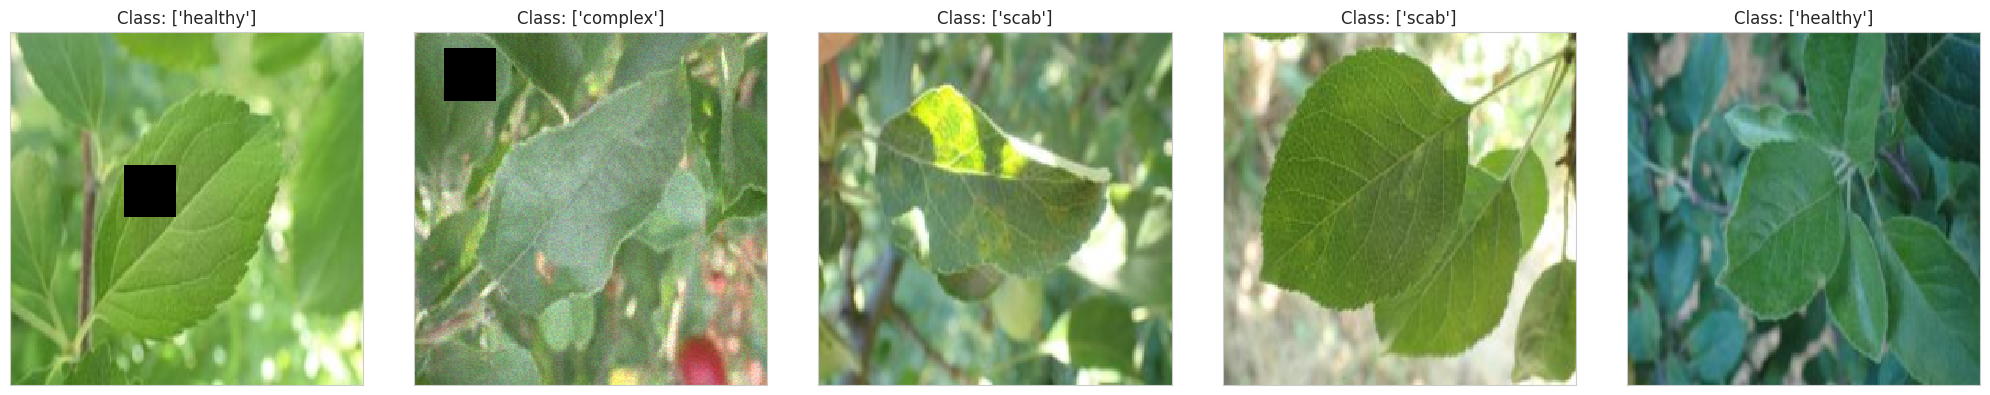

In [14]:
visualize_images(
    images.image,
    images.labels,
    train_dir,
    nrows=1,
    ncols=5,
    image_transform=train_transform
)

Пример аугментации датасета используемого для валидации

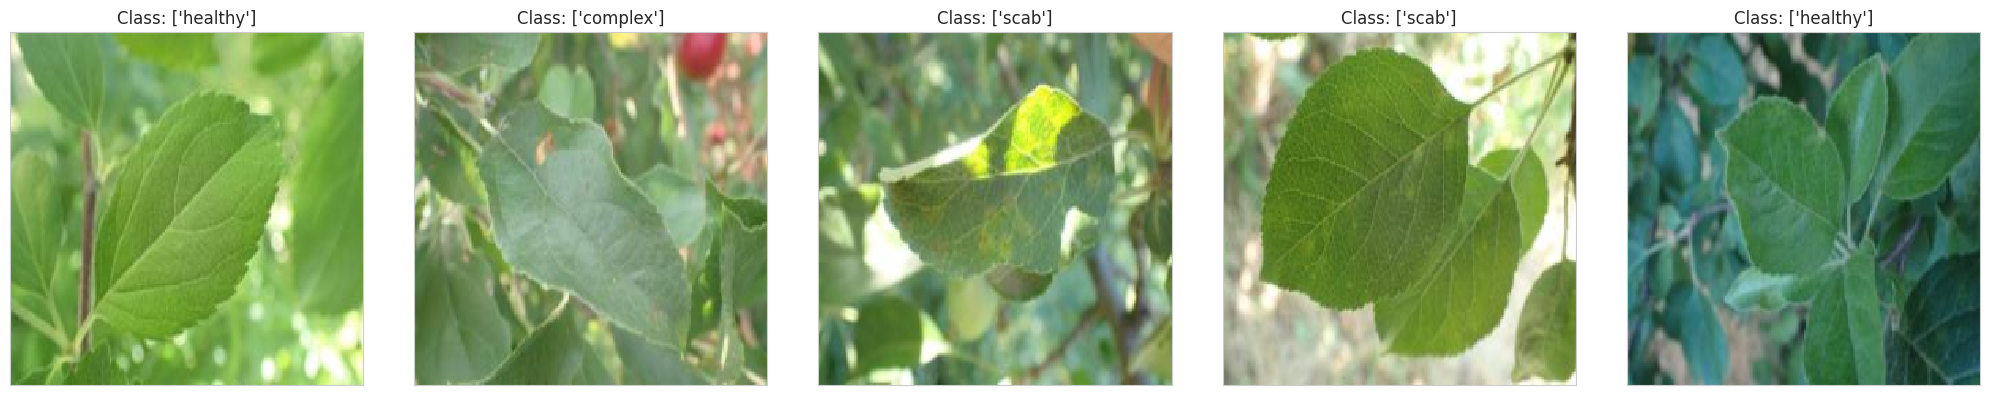

In [15]:
visualize_images(
    images.image,
    images.labels,
    train_dir,
    nrows=1,
    ncols=5,
    image_transform=val_transform
)

Разделим наши данные на тренировочные и валидационные

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    img_labels['image'],
    img_labels.drop(['image'], axis=1),
    test_size=0.3,
    random_state=42
)

Даталоадер

In [17]:
class PlantDataset(Dataset):
    def __init__(self, image_id, labels, transform=None, image_dir=train_dir):
        self.image_id = image_id # ID изображения
        self.labels = labels # Классы изображений
        self.transform = transform # Трансформатор
        self.image_dir = image_dir # Путь к изображениям

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_id = self.image_id.iloc[idx]
        label = torch.tensor(self.labels.iloc[idx].astype('int8'), dtype=torch.float32)


        image_path = self.image_dir + image_id
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        aug = self.transform(image=image)
        image = aug['image'].to(torch.float32)

        return image, label

In [18]:
train_set = PlantDataset(X_train, y_train, transform=train_transform)
val_set = PlantDataset(X_valid, y_valid, transform=val_transform)

In [19]:
train_set[0][0].dtype, train_set[0][1].dtype

(torch.float32, torch.float32)

In [20]:
train_set[0]

(tensor([[[-0.5596, -0.7822, -0.6794,  ..., -0.4568, -0.7650, -0.6452],
          [-0.8164, -0.6794, -0.7308,  ..., -0.4739, -0.6965, -0.4568],
          [-0.5424, -0.7650, -0.6281,  ..., -0.7479, -0.3369, -0.2342],
          ...,
          [-1.1932, -1.1589, -1.1075,  ...,  2.2489,  2.0948,  1.9235],
          [-1.0733, -1.0904, -1.0562,  ...,  1.7694,  2.1975,  2.0605],
          [-1.0904, -1.1760, -1.2617,  ...,  2.2489,  2.0605,  2.2489]],
 
         [[-0.0049, -0.2675, -0.0574,  ..., -0.2500, -0.8452, -0.6527],
          [-0.3375, -0.1450, -0.2500,  ..., -0.5651, -0.6352, -0.4776],
          [ 0.0126, -0.3550, -0.3725,  ..., -0.5126, -0.5826, -0.1450],
          ...,
          [-0.6702, -0.5126, -0.6352,  ...,  2.1835,  2.0434,  2.4286],
          [-0.5126, -0.6527, -0.5126,  ...,  2.0609,  2.4286,  2.4286],
          [-0.6877, -0.5476, -0.7227,  ...,  2.4286,  2.4286,  2.4286]],
 
         [[-0.8458, -0.9853, -0.8458,  ..., -0.2010, -0.8284, -0.4624],
          [-0.9156, -0.9504,

In [21]:
print(f'Train size: {len(train_set)}')
print(f'Validation size: {len(val_set)}')

Train size: 13042
Validation size: 5590


Обучение

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,3,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['Loss']['Train'], label='Training loss', marker ='o')
    plt.plot(history['Loss']['Validation'], label='Validation loss', marker ='o')
    plt.ylabel('Лосс', fontsize=15)
    plt.xlabel('Эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,3,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['Accuracy']['Train'], label='Training Accuracy', marker ='o')
    plt.plot(history['Accuracy']['Validation'], label='Validation accuracy', marker ='o')
    plt.ylabel('Точность', fontsize=15)
    plt.xlabel('Эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,3,3)
    plt.title('F1_score', fontsize=15)
    plt.plot(history['F1_score']['Train'], label='F1_score training', marker ='o')
    plt.plot(history['F1_score']['Validation'], label='F1_score validation', marker ='o')
    plt.ylabel('F1_score', fontsize=15)
    plt.xlabel('Эпоха', fontsize=15)
    plt.legend()

    plt.show()

In [24]:
batch_size = 64

# Загрузка датасета для тренировки. Перемешиваем датасет
train_batch_gen = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
# Загрузка датасета для валидации. Перемешивать не нужно
val_batch_gen = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False
)

Проверка размерностей

In [25]:
for X, y in train_batch_gen:
    print(X.shape, y.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64, 6])


In [26]:
for X, y in val_batch_gen:
    print(X.shape, y.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64, 6])


In [25]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs,
    predictions_train,
    labels_train,
    predictions_val,
    labels_val
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        f1_train = 0
        f1_val = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            logits = torch.sigmoid(logits)# Применяем сигмойду, чтобы значения были между 0 и 1

            loss = criterion(logits, y_batch)

            loss.backward() # транслируем сигнал потерь обратно по графу вычислений
            optimizer.step() #обновление оптимизатора
            optimizer.zero_grad() #очищаем значение градиента

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.detach().cpu().numpy().round()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

            #F1_score
            f1_train += f1_score(y_batch.detach().cpu().numpy(), y_pred, average='micro')

            if epoch == len(range(num_epochs-1)):
                predictions_train.extend(y_pred)
                labels_train.extend(y_batch.detach().cpu().numpy())

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        f1_train /= len(train_batch_gen)
        history['Loss']['Train'].append(train_loss)
        history['Accuracy']['Train'].append(train_acc)
        history['F1_score']['Train'].append(f1_train)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            logits = torch.sigmoid(logits)

            loss = criterion(logits, y_batch)

            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.detach().cpu().numpy().round()
            val_acc += np.mean(y_batch.detach().cpu().numpy() == y_pred)

            #F1_score
            f1_val += f1_score(y_batch.detach().cpu().numpy(), y_pred, average='micro')

            if epoch == len(range(num_epochs-1)):
                predictions_val.extend(y_pred)
                labels_val.extend(y_batch.detach().cpu().numpy())


        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        f1_val /= len(val_batch_gen)
        history['Loss']['Validation'].append(val_loss)
        history['Accuracy']['Validation'].append(val_acc)
        history['F1_score']['Validation'].append(f1_val)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  Training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  Validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  Training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  Validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        print("  F1_score train: \t\t\t{:.2f} %".format(f1_train * 100))
        print("  F1_score validation: \t\t\t{:.2f} %".format(f1_val * 100))

        plot_learning_curves(history)
        scheduler.step()
        gc.collect()
        torch.cuda.empty_cache()

    return model, history

Модель

# **efficientnet b0**

In [26]:
model_efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')
model_efficientnet.classifier[1] = nn.Linear(in_features=1280, out_features=6)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 62.7MB/s]


In [34]:
gc.collect()
torch.cuda.empty_cache()

In [27]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_efficientnet.parameters(), lr=0.01)

In [28]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [29]:
predictions_train_eff = []
labels_train_eff = []
predictions_val_eff = []
labels_val_eff = []

Epoch 21 of 21 took 136.774s
  Training loss (in-iteration): 	0.088507
  Validation loss (in-iteration): 	0.103010
  Training accuracy: 			96.37 %
  Validation accuracy: 			95.92 %
  F1_score train: 			89.81 %
  F1_score validation: 			88.56 %


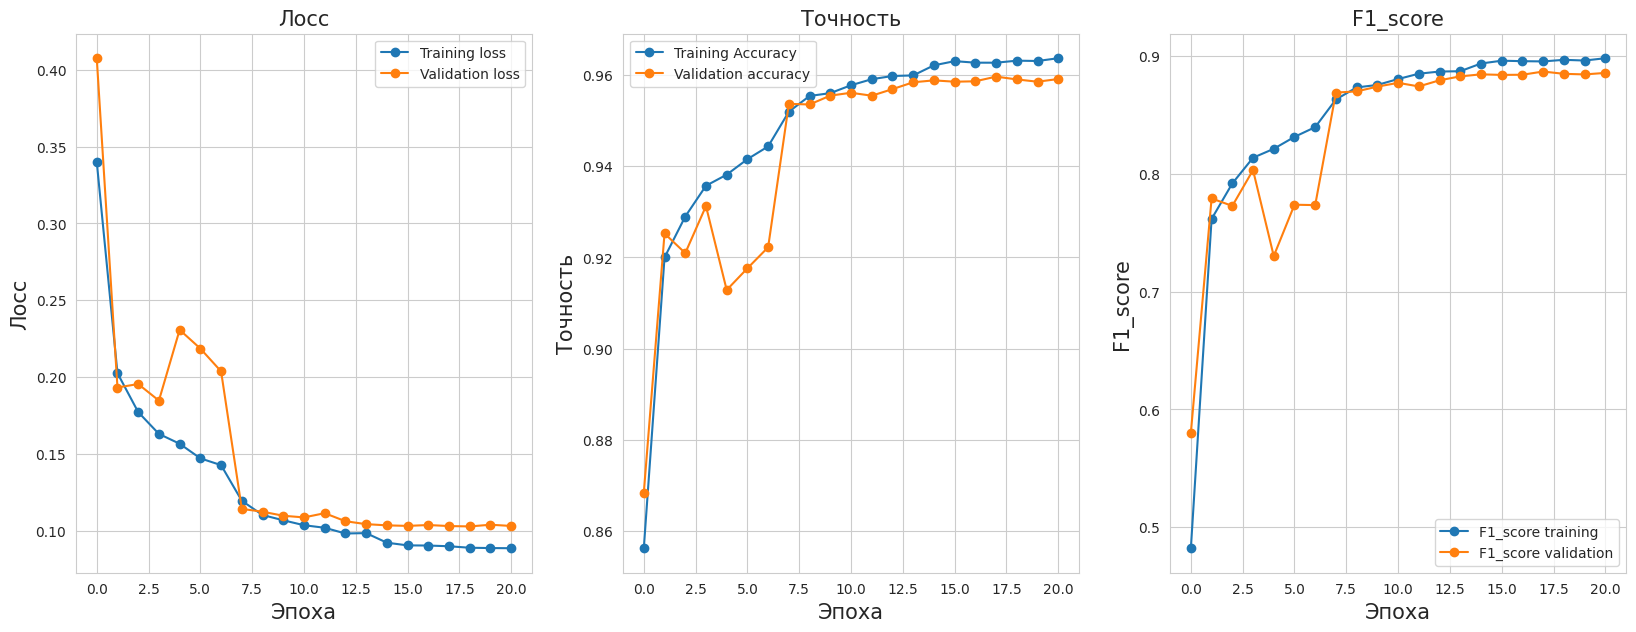

In [30]:
model_efficientnet = model_efficientnet.to(device)

clf_model, history = train(
    model_efficientnet,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=21,
    predictions_train=predictions_train_eff,
    labels_train=labels_train_eff,
    predictions_val=predictions_val_eff,
    labels_val=labels_val_eff
)

In [57]:
def plot_confusion_matrix(y_true_train, y_pred_train, y_true_val, y_pred_val):
    '''
    Функция визуализации матрицы ошибок.
    '''
    cf_matrix_train = confusion_matrix(np.argmax(y_true_train, axis=1), np.argmax(y_pred_train, axis=1))
    cf_matrix_val = confusion_matrix(np.argmax(y_true_val, axis=1), np.argmax(y_pred_val, axis=1))

    disp_train = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_train, display_labels=CLASSES)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_val, display_labels=CLASSES)

    fig, ax = plt.subplots(1, 2)
    ax[0].set_title("Train", size=16)
    ax[1].set_title("Validation", size=16)
    plt.subplots_adjust(right = 2)

    disp_train.plot(ax=ax[0], xticks_rotation=90)
    disp_val.plot(ax=ax[1], xticks_rotation=90)


Матрица ошибок

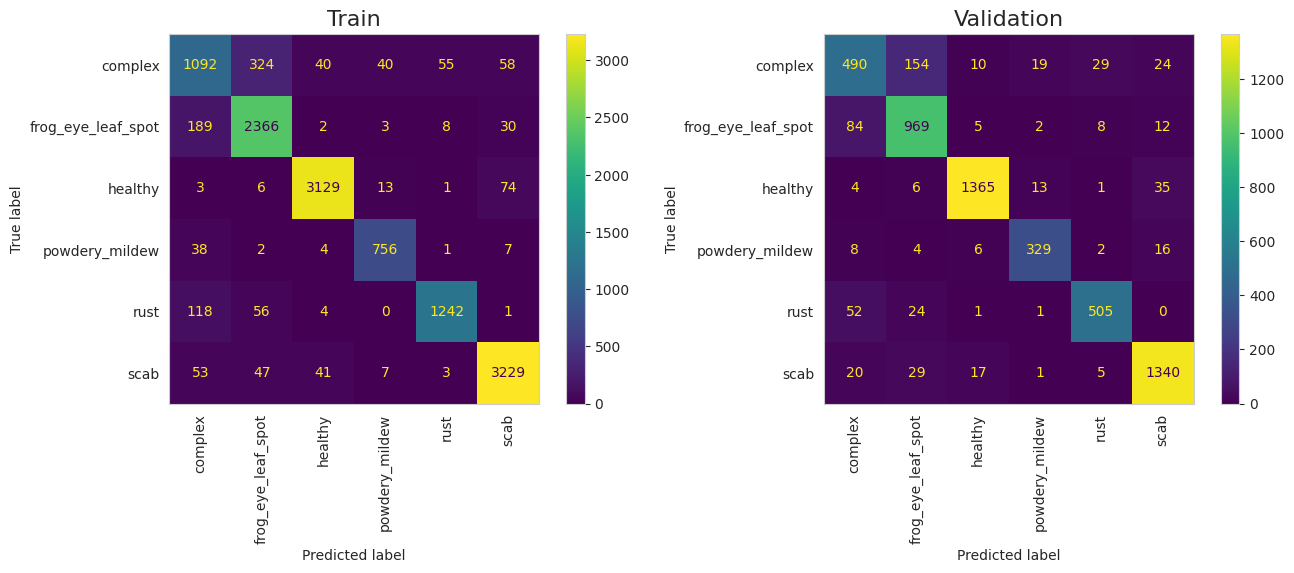

In [58]:
plot_confusion_matrix(predictions_train_eff, labels_train_eff, predictions_val_eff, labels_val_eff)

Тест модели на тестовых изображениях

In [59]:
test_df = pd.read_csv('/content/drive/MyDrive/PLANTS/sample_submission.csv')
test_dir = '/content/test_images/'
!unzip /content/drive/MyDrive/PLANTS/test_images.zip

Archive:  /content/drive/MyDrive/PLANTS/test_images.zip
   creating: test_images/
  inflating: test_images/85f8cb619c66b863.jpg  
  inflating: test_images/ad8770db05586b59.jpg  
  inflating: test_images/c7b03e718489f3ca.jpg  


In [60]:
test_df

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [61]:
tmp = pd.DataFrame(np.zeros([len(test_df), len(CLASSES)]), columns=CLASSES)
test_imgs = pd.concat([test_df, tmp], axis=1)
test_imgs.head()

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,85f8cb619c66b863.jpg,healthy,0.0,0.0,0.0,0.0,0.0,0.0
1,ad8770db05586b59.jpg,healthy,0.0,0.0,0.0,0.0,0.0,0.0
2,c7b03e718489f3ca.jpg,healthy,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
test_set = PlantDataset(test_imgs['image'], labels=test_imgs.drop(['image','labels'], axis=1), transform=val_transform, image_dir=test_dir)

In [63]:
test_batch_gen = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=False
)

In [64]:
for X, y in test_batch_gen:
    print(X.shape, y.shape)
    break

torch.Size([3, 3, 224, 224]) torch.Size([3, 6])


In [70]:
clf_model.to(device)
clf_model.train(False)

predictions = []
for batch in test_batch_gen:
    image = batch[0].to(device)
    #with torch.no_grad():
    logits = clf_model(image)
    logits = torch.sigmoid(logits)

    preds = logits.detach().cpu().numpy().round()
    predictions.append(preds)

In [66]:
torch.save(clf_model, 'clf_model.pth')

In [79]:
predictions

[array([[0., 0., 0., 0., 0., 1.],
        [1., 1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.]], dtype=float32)]

In [80]:
predictions = pd.DataFrame(np.concatenate(predictions), columns=CLASSES)

In [81]:
predictions

,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0


In [82]:
test_imgs.iloc[:, 2:] = predictions
test_imgs

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,85f8cb619c66b863.jpg,healthy,0.0,0.0,0.0,0.0,0.0,1.0
1,ad8770db05586b59.jpg,healthy,1.0,1.0,0.0,0.0,0.0,1.0
2,c7b03e718489f3ca.jpg,healthy,0.0,1.0,0.0,0.0,0.0,0.0


In [83]:
labels = []
for i, row in test_imgs.iloc[:, 2:].iterrows():
    if ((row['healthy'] == 1) or row.sum() == 0):
        tmp = 'healthy'
    else:
        tmp = ' '.join(predictions.columns[row==row.max()])
    labels.append(tmp)

In [84]:
test_imgs['labels'] = labels
test_imgs

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,85f8cb619c66b863.jpg,scab,0.0,0.0,0.0,0.0,0.0,1.0
1,ad8770db05586b59.jpg,complex frog_eye_leaf_spot scab,1.0,1.0,0.0,0.0,0.0,1.0
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot,0.0,1.0,0.0,0.0,0.0,0.0


In [85]:
test_images = test_imgs.sample(n=3)

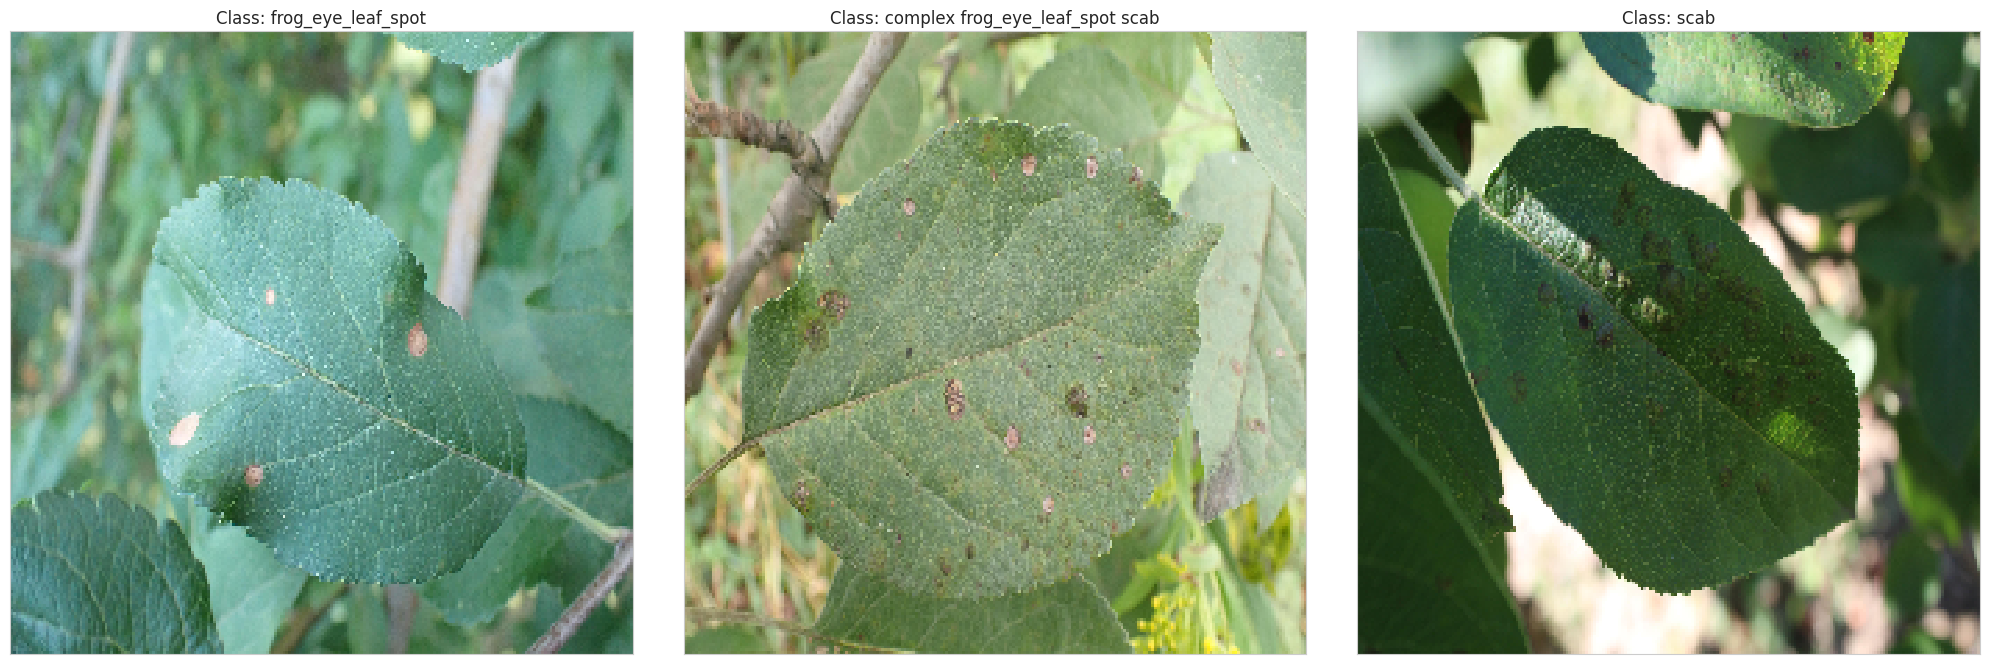

In [86]:
visualize_images(test_images.image, test_images.labels, test_dir, nrows=1, ncols=3, image_transform=val_transform)